# Optimizing EKG Circuit

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [2]:
ohm = UNITS.ohm
farad = UNITS.farad
volt = UNITS.volt
Hz = UNITS.Hz
second = UNITS.second;

In [3]:
input_freq = Params(
    f = 0.5
)

,values
f,0.5


In [4]:
params1 = Params(
    R = 4.9e3,   # ohm
    C = 1e-6,  # farad
    A = 5,      # volt
    f = input_freq.f,   # Hz
    vin = 0
)

,values
R,4900.000000
C,0.000001
A,5.000000
f,0.500000
vin,0.000000


In [5]:
def make_system(params):
    """Makes a System object for the given conditions.
    
    params: Params object
    
    returns: System object
    """
    unpack(params)
    
    init = State(V_out = 0)
    omega = 2 * np.pi * input_freq.f
    tau = R * C
    cutoff = 1 / R / C / 2 / np.pi
    t_end = 4 / input_freq.f
    ts = linspace(0, t_end, 401)
    
    return System(R=R, C=C, A=A, f=input_freq.f,
                  init=init, t_end=t_end, ts=ts,
                  omega=omega, tau=tau, cutoff=cutoff, vin=vin)

In [6]:
system1 = make_system(params1)

,values
R,4900
C,1e-06
A,5
f,0.5
init,V_out 0 dtype: int64
t_end,8
ts,"[0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14,..."
omega,3.14159
tau,0.0049
cutoff,32.4806


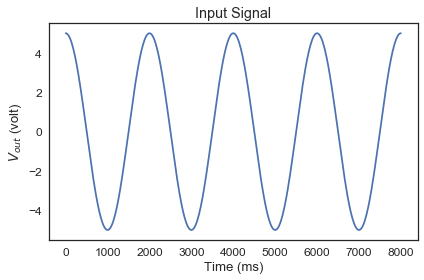

In [7]:
x = linspace(0, system1.t_end * 1000, 401)
v = A * np.cos(2 * pi * (f / 1000) * x)
plt.plot(x, v)
decorate(xlabel='Time (ms)',
             ylabel='$V_{out}$ (volt)',
             title='Input Signal',
             legend=False)

In [8]:
def slope_func_init(state, t, system):
    """Makes a slope function to update the state.
    
    state: State(V_out)
    t: time
    system: System Object
    
    returns: State(V_out)"""

    vout = state
    
    unpack(system)
    
    vin = A * np.cos(2 * pi * f * t)
    
    dvoutdt = (vin - vout) / (R * C)
    
    return dvoutdt

In [9]:
results1, details1 = run_ode_solver(system1, slope_func_init, t_eval=system1.ts)

In [10]:
def plot_results(results):
    xs = results.V_out.index
    ys = results.V_out.values

    t_end = get_last_label(results)
    if t_end < 10:
        xs *= 1000
        xlabel = 'Time (ms)'
    else:
        xlabel = 'Time (s)'
        
    plot(xs, ys)
    decorate(xlabel=xlabel,
             ylabel='$V_{out}$ (volt)',
             legend=False)

In [11]:
params2 = Params(
    R = 100e3,   # ohm
    C = 1e-6,  # farad
    vin = results1.V_out
)

,values
R,100000
C,1e-06
vin,0.00 0.000000 0.02 4.908877 0.04 4.96...


In [12]:
system2 = make_system(params2)

,values
R,100000
C,1e-06
A,5
f,0.5
init,V_out 0 dtype: int64
t_end,8
ts,"[0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14,..."
omega,3.14159
tau,0.1
cutoff,1.59155


In [13]:
def slope_func_high_pass(state, t, system):
    """Makes a slope function to update the state.
    
    state: State(V_out)
    t: time
    system: System Object
    
    returns: State(V_out)
    """
    vout = state
    
    #unpack(system)
    
    vin = interpolate(system.vin)
    
    dvoutdt = ((vin(t) - vout) * (system.R * system.C * system.omega)) / (system.R * system.C)
    
    return dvoutdt

In [14]:
def slope_func_low_pass(state, t, system):
    """Makes a slope function to update the state.
    
    state: State(V_out)
    t: time
    system: System Object
    
    returns: State(V_out)
    """
    vout = state
    
    #unpack(system)
    
    vin = interpolate(system.vin)
    
    dvoutdt = (vin(t) - vout) / (system.R * system.C)
    
    return dvoutdt

In [15]:
results2, details2 = run_ode_solver(system2, slope_func_high_pass, t_eval=system2.ts)

In [16]:
params3 = Params(
    R = 499,   # ohm
    C = 10e-6,  # farad
    vin = results2.V_out
)

,values
R,499
C,1e-05
vin,0.00 0.000000 0.02 0.140523 0.04 0.42...


In [17]:
system3 = make_system(params3)

,values
R,499
C,1e-05
A,5
f,0.5
init,V_out 0 dtype: int64
t_end,8
ts,"[0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14,..."
omega,3.14159
tau,0.00499
cutoff,31.8948


In [18]:
results3, details3 = run_ode_solver(system3, slope_func_low_pass, t_eval=system3.ts)

In [19]:
params4 = Params(
    R = 4.9e3,   # ohm
    C = 1e-6,  # farad
    vin = results3.V_out
)

,values
R,4900
C,1e-06
vin,0.00 0.000000 0.02 0.105790 0.04 0.35...


In [20]:
system4 = make_system(params4)

,values
R,4900
C,1e-06
A,5
f,0.5
init,V_out 0 dtype: int64
t_end,8
ts,"[0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14,..."
omega,3.14159
tau,0.0049
cutoff,32.4806


In [21]:
results4, details4 = run_ode_solver(system4, slope_func_low_pass, t_eval=system4.ts)

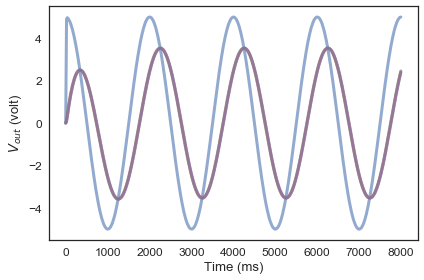

In [22]:
plot_results(results1)
plot_results(results2)
plot_results(results3)
plot_results(results4)

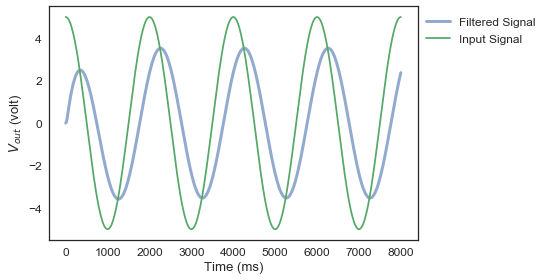

In [38]:
#plt.xkcd()
plot_results(results4)
plt.plot(x, v)
plt.legend(["Filtered Signal", "Input Signal"], loc='upper right', bbox_to_anchor=(1.35, 1))

In [24]:
params_total = Params(
    R1 = 4.9e3,   # ohm
    C1 = 1e-6,  # farad
    
    vin2 = results1.V_out,
    R2 = 100e3,   # ohm
    C2 = 1e-6,  # farad
    
    vin3 = results2.V_out,
    R3 = 499,   # ohm
    C3 = 10e-6,  # farad
    
    vin4 = results3.V_out,
    R4 = 4.9e3,   # ohm
    C4 = 1e-6  # farad
)

,values
R1,4900
C1,1e-06
vin2,0.00 0.000000 0.02 4.908877 0.04 4.96...
R2,100000
C2,1e-06
vin3,0.00 0.000000 0.02 0.140523 0.04 0.42...
R3,499
C3,1e-05
vin4,0.00 0.000000 0.02 0.105790 0.04 0.35...
R4,4900


In [25]:
def run_sim(input_freq, make_system, slope_func_init, slope_func_high_pass, slope_func_low_pass):
    
    params5 = Params(
    R = 4.9e3,   # ohm
    C = 1e-6,  # farad
    A = 5,      # volt
    f = input_freq.f,   # Hz
    vin = 0
    )
    
    system5 = make_system(params5)
    results5, details5 = run_ode_solver(system5, slope_func_init, t_eval=system5.ts)
    
    params6 = Params(
    R = 100e3,   # ohm
    C = 1e-6,  # farad
    vin = results5.V_out
    )
    
    system6 = make_system(params6)
    results6, details6 = run_ode_solver(system6, slope_func_high_pass, t_eval=system6.ts)
    
    params7 = Params(
    R = 499,   # ohm
    C = 10e-6,  # farad
    vin = results6.V_out
    )
    
    system7 = make_system(params7)
    results7, details7 = run_ode_solver(system7, slope_func_low_pass, t_eval=system7.ts)
    
    params8 = Params(
    R = 4.9e3,   # ohm
    C = 1e-6,  # farad
    vin = results7.V_out
    )
    
    system8 = make_system(params8)
    results8, details8 = run_ode_solver(system8, slope_func_low_pass, t_eval=system8.ts)
    
    A_in = params5.A
    
    A_out=(results8.V_out.max()-results8.V_out.min())/2
        
    ratio = A_out/A_in
    
    return State(results5=results5, results6=results6, result7=results7, results8=results8, ratio=ratio)

In [26]:
input_freq.f = 50

In [27]:
results5, results6, results7, results8, ratio = run_sim(input_freq, make_system, slope_func_init, slope_func_high_pass, slope_func_low_pass)

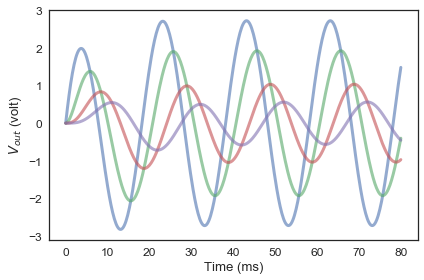

In [43]:
plot_results(results5)
plot_results(results6)
plot_results(results7)
plot_results(results8)

In [44]:
sweep = SweepSeries()
for f in linspace(0.25, 100, 50):
    print(f/100)
    input_freq.f=f
    state = run_sim(input_freq, make_system, slope_func_init, slope_func_high_pass, slope_func_low_pass).ratio
    sweep[f] = state

0.0025
0.022857142857142857
0.04321428571428571
0.06357142857142857
0.08392857142857142
0.10428571428571427
0.12464285714285714
0.145
0.16535714285714284
0.1857142857142857
0.20607142857142854
0.22642857142857142
0.24678571428571427
0.2671428571428571
0.2875
0.30785714285714283
0.3282142857142857
0.34857142857142853
0.3689285714285714
0.38928571428571423
0.4096428571428571
0.43
0.45035714285714284
0.4707142857142857
0.49107142857142855
0.5114285714285713
0.5317857142857142
0.552142857142857
0.5725
0.5928571428571429
0.6132142857142857
0.6335714285714286
0.6539285714285714
0.6742857142857143
0.6946428571428571
0.715
0.7353571428571428
0.7557142857142857
0.7760714285714285
0.7964285714285714
0.8167857142857141
0.8371428571428571
0.8575
0.8778571428571428
0.8982142857142857
0.9185714285714285
0.9389285714285713
0.9592857142857142
0.979642857142857
1.0


In [45]:
sweep

,values
0.250000,0.711794
2.285714,0.706247
4.321429,0.693046
6.357143,0.672663
8.392857,0.645954
10.428571,0.614957
12.464286,0.580445
14.500000,0.544354
16.535714,0.507663
18.571429,0.471014


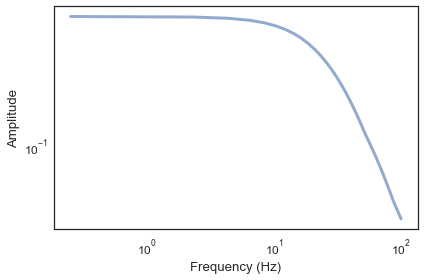

In [46]:
plot(sweep)
decorate(xlabel='Frequency (Hz)',
             ylabel='Amplitude',
             xscale='log',
             yscale='log')